In [1]:
import pickle

file = open('/home/tom/work/rltensor/rltensor/app/ticker1.pkl', 'rb')
tickers = pickle.loads(file.read())
tickers = tickers[1:]
print(tickers)

['USDT_BTC', 'USDT_DASH', 'USDT_ETC', 'USDT_ETH', 'USDT_LTC', 'USDT_XMR', 'USDT_ZEC']


from pytrade_env.database.utils import get_data
import pandas as pd


start = '2018-06-01 00:00:00'
# end = '2018-09-01 00:00:00'
start = '2016-07-01 00:00:00'
# start = '2018-03-01 00:00:00'
end = '2018-09-01 00:04:00'
dfs = dict()
index = None
tickers = tickers
for ticker in tickers:
    df = get_data(ticker, start, end, period=1800)
    df = df.dropna()
    df_ = df[['high', 'low', 'close', 'open', 'volume']]
    time_idx = pd.DatetimeIndex(df['date'])
    # print(ticker, time_idx)
    df_.index = time_idx
    dfs[ticker] = df_
    if index is None:
        index = df_.index
    else:
        index = index & df_.index
        
for ticker in tickers:
    dfs[ticker] = dfs[ticker].loc[index]
    

cash = deepcopy(dfs[tickers[0]])
for col in cash.columns:
    cash[col] = 1.
dfs[tickers[-1]] = cash
    
for ticker in tickers:
    dfs[ticker].to_csv(f'../datasets/crypto/{ticker}.csv')

In [2]:
import pandas as pd
dfs = dict()
# tickers = tickers[:1]
for ticker in tickers:
    df = pd.read_csv(f'../datasets/crypto/{ticker}.csv')
    df.index = pd.DatetimeIndex(df['date'])
    del df['date']
    dfs[ticker] = df

In [4]:
%%time
import backtrader as bt

from btbot import get_cerebro
from btbot.strategies import RLStrategy
from rl_traders.agents import EIIEAgent

cerebro = get_cerebro(startcash=1e10)

for ticker in tickers:
    df = dfs[ticker]
    cols = list(df.columns)
    close_idx = cols.index('close')
    high_idx = cols.index('high')
    low_idx = cols.index('low')
    open_idx = cols.index('open')
    volume_idx =cols.index('volume')
    stock = bt.feeds.PandasData(dataname=df, close=close_idx, high=high_idx,
                                low=low_idx, open=open_idx, volume=volume_idx)
    cerebro.adddata(stock, name=ticker)
    
action_spec = {'shape': len(tickers) + 1, 'type': 'continuous'}

LR_SPEC = {"lr": 3.0e-5, 'name': 'adam'}
SCHEDULER_SPEC = {'name': 'plateau', 'patience': 1000, 'factor': 0.9, 'min_lr': 3.0e-5}
# SCHEDULER_SPEC = {'name': 'step', 'patience': 100, 'factor': 0.5, 'min_lr': 3.0e-5}

EIIE_CONFIG = {
    'lower_params': [{"name": "conv2d", "kernel_size": (3, 1),
                     "in_channels": 3, "out_channels": 2, "stride": 1},
                     # {"name": "batch2d", 'num_features': 2},
                     {"name": "relu"},
                     {"name": "conv2d", "kernel_size": (48, 1),
                      "in_channels": 2, "out_channels": 20, "stride": 1},
                     {"name": "batch2d", 'num_features': 20},
                     {"name": "relu"},],
    'upper_params': [{"name": "conv2d", "kernel_size": (1, 1),
                     "in_channels": 21, "out_channels": 1, "stride": 1},
                     {"name": "flatten"}],
}

keys=['close', 'high', 'low']
COMMISSION = 2.5e-3
COMMISSION = 0.0
agent = EIIEAgent(action_spec, model_params=EIIE_CONFIG,
                 memory_limit=100000, window_length=50,
                 batch_size=50, beta=5.0e-5, lr_spec=LR_SPEC, scheduler_spec=SCHEDULER_SPEC,
                 keys=keys, comm_rate=COMMISSION, log_hist_freq=None, is_notebook=True)

warmup = 30000
# warmup = 1000
train_n_epochs = int(2 * 1e6)
# train_n_epochs = 10
cerebro.broker.setcommission(commission=COMMISSION) 
cerebro.addstrategy(RLStrategy, train_freq=1, debug=False,
                    warmup=warmup, agent=agent, train_n_epochs=train_n_epochs, test_n_epochs=30,
                    tickers=tickers, keys=keys)
strategy = cerebro.run()[0]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Delete old tensorboard log


HBox(children=(IntProgress(value=0, max=2000000), HTML(value='')))

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              30006
3: Current date:                         2018-07-15
4: Status:                               Trade Complete
5: Ref:                                  4
6: PnL:                                  1.96
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30020
3: Current date:                         2018-07-16
4: Status:                               Trade Complete
5: Ref:                                  2
6: PnL:                                  14362092.98
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Nu

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30060
3: Current date:                         2018-07-17
4: Status:                               Trade Complete
5: Ref:                                  21
6: PnL:                                  -121304.87
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30060
3: Current date:                         2018-07-17
4: Status:                               Trade Complete
5: Ref:                                  25
6: PnL:                                  -14211.57
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              30094
3: Current date:                         2018-07-17
4: Status:                               Trade Complete
5: Ref:                                  32
6: PnL:                                  28186258.89
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30095
3: Current date:                         2018-07-17
4: Status:                               Trade Complete
5: Ref:                                  40
6: PnL:                                  338610342.13
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30130
3: Current date:                         2018-07-18
4: Status:                               Trade Complete
5: Ref:                                  54
6: PnL:                                  -12890529.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              30131
3: Current date:                         2018-07-18
4: Status:                               Trade Complete
5: Ref:                                  59
6: PnL:                                  97880334.98
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC


---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30183
3: Current date:                         2018-07-19
4: Status:                               Trade Complete
5: Ref:                                  78
6: PnL:                                  494907.64
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              30187
3: Current date:                         2018-07-19
4: Status:                               Trade Complete
5: Ref:                                  79
6: PnL:                                  28477816.94
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              30220
3: Current date:                         2018-07-20
4: Status:                               Trade Complete
5: Ref:                                  99
6: PnL:                                  194870181.14
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              30221
3: Current date:                         2018-07-20
4: Status:                               Trade Complete
5: Ref:                                  96
6: PnL:                                  -1275761.2
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH


---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              30267
3: Current date:                         2018-07-21
4: Status:                               Trade Complete
5: Ref:                                  118
6: PnL:                                  -16052.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30272
3: Current date:                         2018-07-21
4: Status:                               Trade Complete
5: Ref:                                  112
6: PnL:                                  -73091203.28
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC


---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              30313
3: Current date:                         2018-07-22
4: Status:                               Trade Complete
5: Ref:                                  138
6: PnL:                                  0.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              30317
3: Current date:                         2018-07-22
4: Status:                               Trade Complete
5: Ref:                                  137
6: PnL:                                  6518502.16
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30353
3: Current date:                         2018-07-23
4: Status:                               Trade Complete
5: Ref:                                  157
6: PnL:                                  163.24
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              30353
3: Current date:                         2018-07-23
4: Status:                               Trade Complete
5: Ref:                                  155
6: PnL:                                  1619.91
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar N

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30400
3: Current date:                         2018-07-24
4: Status:                               Trade Complete
5: Ref:                                  176
6: PnL:                                  -13459851.14
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              30403
3: Current date:                         2018-07-24
4: Status:                               Trade Complete
5: Ref:                                  178
6: PnL:                                  -21583098.41
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30457
3: Current date:                         2018-07-25
4: Status:                               Trade Complete
5: Ref:                                  198
6: PnL:                                  -6340.98
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30458
3: Current date:                         2018-07-25
4: Status:                               Trade Complete
5: Ref:                                  197
6: PnL:                                  4.07
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar N

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30486
3: Current date:                         2018-07-25
4: Status:                               Trade Complete
5: Ref:                                  213
6: PnL:                                  -33619327.95
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30491
3: Current date:                         2018-07-26
4: Status:                               Trade Complete
5: Ref:                                  217
6: PnL:                                  -269490.06
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LT

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              30528
3: Current date:                         2018-07-26
4: Status:                               Trade Complete
5: Ref:                                  232
6: PnL:                                  1666.88
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30531
3: Current date:                         2018-07-26
4: Status:                               Trade Complete
5: Ref:                                  236
6: PnL:                                  15397271.06
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2:

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30565
3: Current date:                         2018-07-27
4: Status:                               Trade Complete
5: Ref:                                  253
6: PnL:                                  -585088.47
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30565
3: Current date:                         2018-07-27
4: Status:                               Trade Complete
5: Ref:                                  255
6: PnL:                                  -36104224.79
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ET

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30610
3: Current date:                         2018-07-28
4: Status:                               Trade Complete
5: Ref:                                  272
6: PnL:                                  -144847.92
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              30610
3: Current date:                         2018-07-28
4: Status:                               Trade Complete
5: Ref:                                  275
6: PnL:                                  -67779.42
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30645
3: Current date:                         2018-07-29
4: Status:                               Trade Complete
5: Ref:                                  293
6: PnL:                                  18695359.45
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30645
3: Current date:                         2018-07-29
4: Status:                               Trade Complete
5: Ref:                                  291
6: PnL:                                  -3096544.67
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LT

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              30691
3: Current date:                         2018-07-30
4: Status:                               Trade Complete
5: Ref:                                  305
6: PnL:                                  -1679.46
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30699
3: Current date:                         2018-07-30
4: Status:                               Trade Complete
5: Ref:                                  312
6: PnL:                                  -51512272.21
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              30732
3: Current date:                         2018-07-31
4: Status:                               Trade Complete
5: Ref:                                  332
6: PnL:                                  57735125.76
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              30736
3: Current date:                         2018-07-31
4: Status:                               Trade Complete
5: Ref:                                  331
6: PnL:                                  3602.16
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30770
3: Current date:                         2018-07-31
4: Status:                               Trade Complete
5: Ref:                                  347
6: PnL:                                  -24541.28
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              30770
3: Current date:                         2018-07-31
4: Status:                               Trade Complete
5: Ref:                                  349
6: PnL:                                  -82917529.39
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC


---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30821
3: Current date:                         2018-08-01
4: Status:                               Trade Complete
5: Ref:                                  370
6: PnL:                                  485668.82
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30821
3: Current date:                         2018-08-01
4: Status:                               Trade Complete
5: Ref:                                  369
6: PnL:                                  -5811811.59
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC


---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30869
3: Current date:                         2018-08-02
4: Status:                               Trade Complete
5: Ref:                                  384
6: PnL:                                  43515907.77
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              30876
3: Current date:                         2018-08-03
4: Status:                               Trade Complete
5: Ref:                                  388
6: PnL:                                  -175.84
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2:

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30924
3: Current date:                         2018-08-04
4: Status:                               Trade Complete
5: Ref:                                  406
6: PnL:                                  34746976.13
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              30930
3: Current date:                         2018-08-04
4: Status:                               Trade Complete
5: Ref:                                  409
6: PnL:                                  -70361788.59
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_B

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30984
3: Current date:                         2018-08-05
4: Status:                               Trade Complete
5: Ref:                                  424
6: PnL:                                  3031320.98
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              30988
3: Current date:                         2018-08-05
4: Status:                               Trade Complete
5: Ref:                                  431
6: PnL:                                  1650284.04
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31025
3: Current date:                         2018-08-06
4: Status:                               Trade Complete
5: Ref:                                  438
6: PnL:                                  -365993.23
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31026
3: Current date:                         2018-08-06
4: Status:                               Trade Complete
5: Ref:                                  448
6: PnL:                                  7179.38
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: B

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31058
3: Current date:                         2018-08-06
4: Status:                               Trade Complete
5: Ref:                                  467
6: PnL:                                  101514.89
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31063
3: Current date:                         2018-08-06
4: Status:                               Trade Complete
5: Ref:                                  470
6: PnL:                                  -374.34
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: B

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31097
3: Current date:                         2018-08-07
4: Status:                               Trade Complete
5: Ref:                                  488
6: PnL:                                  -1531216.23
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31099
3: Current date:                         2018-08-07
4: Status:                               Trade Complete
5: Ref:                                  490
6: PnL:                                  14966697.91
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DAS

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31143
3: Current date:                         2018-08-08
4: Status:                               Trade Complete
5: Ref:                                  508
6: PnL:                                  -6.86
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31143
3: Current date:                         2018-08-08
4: Status:                               Trade Complete
5: Ref:                                  501
6: PnL:                                  -188528970.47
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2:

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              31182
3: Current date:                         2018-08-09
4: Status:                               Trade Complete
5: Ref:                                  525
6: PnL:                                  455.77
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31187
3: Current date:                         2018-08-09
4: Status:                               Trade Complete
5: Ref:                                  530
6: PnL:                                  -31956.64
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              31221
3: Current date:                         2018-08-10
4: Status:                               Trade Complete
5: Ref:                                  548
6: PnL:                                  -3.77
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31225
3: Current date:                         2018-08-10
4: Status:                               Trade Complete
5: Ref:                                  551
6: PnL:                                  1.71
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num: 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              31259
3: Current date:                         2018-08-11
4: Status:                               Trade Complete
5: Ref:                                  563
6: PnL:                                  94957282.83
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31260
3: Current date:                         2018-08-11
4: Status:                               Trade Complete
5: Ref:                                  568
6: PnL:                                  1891659.09
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31297
3: Current date:                         2018-08-11
4: Status:                               Trade Complete
5: Ref:                                  588
6: PnL:                                  -3988.94
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31297
3: Current date:                         2018-08-11
4: Status:                               Trade Complete
5: Ref:                                  582
6: PnL:                                  35112774.92
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              31342
3: Current date:                         2018-08-12
4: Status:                               Trade Complete
5: Ref:                                  608
6: PnL:                                  -219.82
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              31342
3: Current date:                         2018-08-12
4: Status:                               Trade Complete
5: Ref:                                  603
6: PnL:                                  -546.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31390
3: Current date:                         2018-08-13
4: Status:                               Trade Complete
5: Ref:                                  616
6: PnL:                                  99379959.98
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              31390
3: Current date:                         2018-08-13
4: Status:                               Trade Complete
5: Ref:                                  622
6: PnL:                                  -900445276.77
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_E

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              31428
3: Current date:                         2018-08-14
4: Status:                               Trade Complete
5: Ref:                                  647
6: PnL:                                  -1028660.43
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31429
3: Current date:                         2018-08-14
4: Status:                               Trade Complete
5: Ref:                                  642
6: PnL:                                  -421192.58
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              31465
3: Current date:                         2018-08-15
4: Status:                               Trade Complete
5: Ref:                                  658
6: PnL:                                  62398422.56
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              31465
3: Current date:                         2018-08-15
4: Status:                               Trade Complete
5: Ref:                                  664
6: PnL:                                  22604593.28
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31509
3: Current date:                         2018-08-16
4: Status:                               Trade Complete
5: Ref:                                  686
6: PnL:                                  65.86
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              31514
3: Current date:                         2018-08-16
4: Status:                               Trade Complete
5: Ref:                                  679
6: PnL:                                  -60178639.16
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31547
3: Current date:                         2018-08-17
4: Status:                               Trade Complete
5: Ref:                                  700
6: PnL:                                  -57805.82
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31551
3: Current date:                         2018-08-17
4: Status:                               Trade Complete
5: Ref:                                  704
6: PnL:                                  7004.67
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Ba

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31594
3: Current date:                         2018-08-17
4: Status:                               Trade Complete
5: Ref:                                  719
6: PnL:                                  -7102234.64
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31599
3: Current date:                         2018-08-18
4: Status:                               Trade Complete
5: Ref:                                  722
6: PnL:                                  -34362152.05
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              31630
3: Current date:                         2018-08-18
4: Status:                               Trade Complete
5: Ref:                                  739
6: PnL:                                  2051.27
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31630
3: Current date:                         2018-08-18
4: Status:                               Trade Complete
5: Ref:                                  738
6: PnL:                                  -9.41
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Nu

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31667
3: Current date:                         2018-08-19
4: Status:                               Trade Complete
5: Ref:                                  760
6: PnL:                                  0.73
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31668
3: Current date:                         2018-08-19
4: Status:                               Trade Complete
5: Ref:                                  762
6: PnL:                                  61.62
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31709
3: Current date:                         2018-08-20
4: Status:                               Trade Complete
5: Ref:                                  777
6: PnL:                                  -9826.16
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31710
3: Current date:                         2018-08-20
4: Status:                               Trade Complete
5: Ref:                                  778
6: PnL:                                  -24497.28
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:                              31747
3: Current date:                         2018-08-21
4: Status:                               Trade Complete
5: Ref:                                  795
6: PnL:                                  -13876272.84
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              31754
3: Current date:                         2018-08-21
4: Status:                               Trade Complete
5: Ref:                                  796
6: PnL:                                  148.82
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: 

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31789
3: Current date:                         2018-08-22
4: Status:                               Trade Complete
5: Ref:                                  810
6: PnL:                                  305434255.8
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              31791
3: Current date:                         2018-08-22
4: Status:                               Trade Complete
5: Ref:                                  816
6: PnL:                                  94.99
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Ba

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              31842
3: Current date:                         2018-08-23
4: Status:                               Trade Complete
5: Ref:                                  837
6: PnL:                                  -36504860.22
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31847
3: Current date:                         2018-08-23
4: Status:                               Trade Complete
5: Ref:                                  834
6: PnL:                                  25069785.02
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_D

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              31889
3: Current date:                         2018-08-24
4: Status:                               Trade Complete
5: Ref:                                  856
6: PnL:                                  2.55
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31892
3: Current date:                         2018-08-24
4: Status:                               Trade Complete
5: Ref:                                  857
6: PnL:                                  0.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar Num:  

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETH
2: Bar Num:                              31941
3: Current date:                         2018-08-25
4: Status:                               Trade Complete
5: Ref:                                  869
6: PnL:                                  16370418.43
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              31943
3: Current date:                         2018-08-25
4: Status:                               Trade Complete
5: Ref:                                  872
6: PnL:                                  9169243.4
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR


---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              31999
3: Current date:                         2018-08-26
4: Status:                               Trade Complete
5: Ref:                                  899
6: PnL:                                  1.91
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              32002
3: Current date:                         2018-08-26
4: Status:                               Trade Complete
5: Ref:                                  900
6: PnL:                                  404641.22
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2: Bar N

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2: Bar Num:                              32041
3: Current date:                         2018-08-27
4: Status:                               Trade Complete
5: Ref:                                  916
6: PnL:                                  27307506.39
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              32046
3: Current date:                         2018-08-27
4: Status:                               Trade Complete
5: Ref:                                  921
6: PnL:                                  -258.05
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BTC
2:

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              32107
3: Current date:                         2018-08-28
4: Status:                               Trade Complete
5: Ref:                                  933
6: PnL:                                  3865.86
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              32109
3: Current date:                         2018-08-28
4: Status:                               Trade Complete
5: Ref:                                  937
6: PnL:                                  285664167.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_XMR
2: Bar Num:                              32143
3: Current date:                         2018-08-29
4: Status:                               Trade Complete
5: Ref:                                  955
6: PnL:                                  1021140.97
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              32145
3: Current date:                         2018-08-29
4: Status:                               Trade Complete
5: Ref:                                  957
6: PnL:                                  103568786.71
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BT

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              32191
3: Current date:                         2018-08-30
4: Status:                               Trade Complete
5: Ref:                                  979
6: PnL:                                  -197.64
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ZEC
2: Bar Num:                              32193
3: Current date:                         2018-08-30
4: Status:                               Trade Complete
5: Ref:                                  976
6: PnL:                                  201527649.88
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_ETC
2:

---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_LTC
2: Bar Num:                              32242
3: Current date:                         2018-08-31
4: Status:                               Trade Complete
5: Ref:                                  999
6: PnL:                                  -24332147.99
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_DASH
2: Bar Num:                              32243
3: Current date:                         2018-08-31
4: Status:                               Trade Complete
5: Ref:                                  995
6: PnL:                                  2997997.05
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            USDT_BT

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

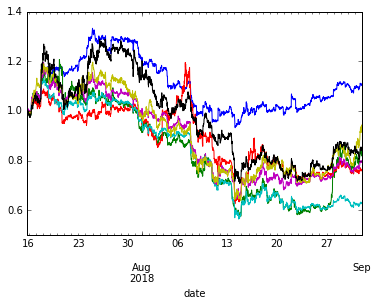

In [11]:
for ticker in tickers:
    value = dfs[ticker]['close'].iloc[30000:]
    value /= value.iloc[0]
    value.plot()

In [13]:
import numpy as np

In [63]:
np.random.geometric(.5)

1

In [158]:
np.arange(10)[:-2]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [10]:
x = torch.randn(3, 4)

In [12]:
x[:, :, None].shape

torch.Size([3, 4, 1])

In [3]:
import numpy as np

In [152]:

np.random.geometric(1e-5)

78604

In [41]:
np.random.dirichlet(np.ones(8))

array([0.00979748, 0.01455425, 0.19689315, 0.14715224, 0.20706454,
       0.30587335, 0.00272339, 0.11594161])

In [40]:
help(np.random.dirichlet)

Help on built-in function dirichlet:

dirichlet(...) method of mtrand.RandomState instance
    dirichlet(alpha, size=None)
    
    Draw samples from the Dirichlet distribution.
    
    Draw `size` samples of dimension k from a Dirichlet distribution. A
    Dirichlet-distributed random variable can be seen as a multivariate
    generalization of a Beta distribution. Dirichlet pdf is the conjugate
    prior of a multinomial in Bayesian inference.
    
    Parameters
    ----------
    alpha : array
        Parameter of the distribution (k dimension for sample of
        dimension k).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    
    Returns
    -------
    samples : ndarray,
        The drawn samples, of shape (size, alpha.ndim).
    
    Raises
    -------
    ValueError
        If any value in alpha is le